In [1]:
import os

def count_files(folder, extensions):
    count = 0
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(extensions):
                count += 1
    return count

# Chemins (à adapter si nécessaire)
image_train_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\images\train\cats"
audio_train_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\train\cats"
spec_test_cats  = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\spectrograms\test\cats"

print("Images train (cats) :", count_files(image_train_cats, (".jpg",".jpeg",".png")))
print("Audios train (cats)  :", count_files(audio_train_cats, (".wav",)))
print("Spectrograms test (cats) :", count_files(spec_test_cats, (".png",)))


Images train (cats) : 4000
Audios train (cats)  : 427
Spectrograms test (cats) : 111


In [2]:
import pandas as pd

# Chargez votre mapping (par exemple pour le test)
mapping_csv = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df = pd.read_csv(mapping_csv)

print("Distribution des labels dans le mapping :")
print(df['label'].value_counts())


Distribution des labels dans le mapping :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


In [3]:
import pandas as pd

TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df_test = pd.read_csv(TEST_CSV)
print("Distribution des labels dans le mapping de test :")
print(df_test['label'].value_counts())


Distribution des labels dans le mapping de test :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


=== Vérification de la structure des dossiers ===
Images test (cats): 1000
Audios test (cats): 111
Spectrograms test (cats): 111

=== Distribution des labels dans le mapping de test ===
label
0    1000
1    1000
2     343
Name: count, dtype: int64

Nombre d'échantillons de test utilisés : 2343

🔄 Chargement du modèle fusionné...



✅ Modèle fusionné chargé.

🔄 Prédictions sur le jeu de test...
74/74 [==============================] - 2s 30ms/step

=== Rapport de classification ===
              precision    recall  f1-score   support

        Chat       0.83      0.99      0.90      1000
       Chien       0.84      0.96      0.90      1000
      Erreur       0.00      0.00      0.00       343

    accuracy                           0.83      2343
   macro avg       0.56      0.65      0.60      2343
weighted avg       0.71      0.83      0.77      2343



c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


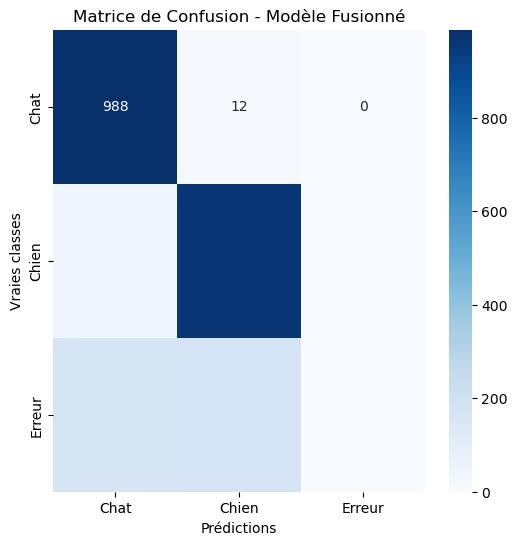

🎯 Accuracy du modèle fusionné sur le test: 83.27%


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ======= 1. Vérification de la structure des dossiers =======
def count_files(folder, extensions):
    count = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(extensions):
                count += 1
    return count

# Exemple pour les chats en test
image_dir_test_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\images\test\cats"
audio_dir_test_cats = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\test\cats"
spec_dir_test_cats  = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\spectrograms\test\cats"

print("=== Vérification de la structure des dossiers ===")
print("Images test (cats):", count_files(image_dir_test_cats, (".jpg", ".jpeg", ".png")))
print("Audios test (cats):", count_files(audio_dir_test_cats, (".wav",)))
print("Spectrograms test (cats):", count_files(spec_dir_test_cats, (".png",)))
print("==============================================\n")

# ======= 2. Vérification du mapping de test =======
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df = pd.read_csv(TEST_CSV)
print("=== Distribution des labels dans le mapping de test ===")
print(df["label"].value_counts())
print("========================================================\n")

# ======= 3. Prétraitement des images et spectrogrammes =======
def preprocess_image(image_path):
    """Charge et prétraite une image en niveaux de gris (64x64, normalisée)."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Image non trouvée : {image_path}")
        return None
    img = cv2.resize(img, (64, 64)) / 255.0
    return img.reshape(64, 64, 1)

def preprocess_audio(audio_path):
    r"""
    Convertit le chemin d'un fichier audio en chemin vers le spectrogramme correspondant.
    On suppose que le fichier audio se trouve dans un chemin contenant "\cleaned\audio"
    et que le spectrogramme se trouve dans le même chemin avec "\spectrograms" à la place,
    et l'extension ".wav" remplacée par ".png".

    Exemple :
    Audio :  C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\test\cats\cat0012.wav
    Spec :  C:\Users\briac\Desktop\projet_3\data\data_fusion_model\spectrograms\test\cats\cat0012.png
    """
    spec_path = audio_path.replace(r"\cleaned\audio", r"\spectrograms").replace(".wav", ".png")
    if not os.path.exists(spec_path):
        print(f"❌ Spectrogramme non trouvé : {spec_path}")
        return None
    spec_img = cv2.imread(spec_path, cv2.IMREAD_GRAYSCALE)
    if spec_img is None:
        print(f"❌ Erreur lors du chargement du spectrogramme : {spec_path}")
        return None
    spec_img = cv2.resize(spec_img, (64, 64)) / 255.0
    return spec_img.reshape(64, 64, 1)

# Chargement du mapping de test et prétraitement
X_images, X_audio, y_true = [], [], []
for _, row in df.iterrows():
    image_path = row["image_path"]
    audio_path = row["audio_path"]
    if not os.path.exists(image_path):
        print(f"❌ Chemin image inexistant : {image_path}")
        continue
    if not os.path.exists(audio_path):
        print(f"❌ Chemin audio inexistant : {audio_path}")
        continue
    img = preprocess_image(image_path)
    aud = preprocess_audio(audio_path)
    if img is None or aud is None:
        continue
    X_images.append(img)
    X_audio.append(aud)
    y_true.append(int(row["label"]))

if len(X_images) == 0 or len(X_audio) == 0:
    print("❌ Aucun échantillon de test valide trouvé.")
    exit()

X_images = np.array(X_images)
X_audio = np.array(X_audio)
y_true = np.array(y_true)
print(f"Nombre d'échantillons de test utilisés : {X_images.shape[0]}\n")

# ======= 4. Chargement du modèle fusionné =======
# Utiliser le chemin absolu pour le modèle fusionné
FUSION_MODEL_PATH = r"C:\Users\briac\Desktop\projet_3\models\image_audio_fusion_model_v2.keras"
print("🔄 Chargement du modèle fusionné...")
fusion_model = tf.keras.models.load_model(FUSION_MODEL_PATH)
print("✅ Modèle fusionné chargé.\n")

# ======= 5. Prédictions =======
print("🔄 Prédictions sur le jeu de test...")
y_pred_probs = fusion_model.predict([X_images, X_audio])
y_pred = np.argmax(y_pred_probs, axis=1)

# ======= 6. Évaluation =======
label_names = {0: "Chat", 1: "Chien", 2: "Erreur"}
target_names = [label_names[0], label_names[1], label_names[2]]

print("\n=== Rapport de classification ===")
print(classification_report(y_true, y_pred, target_names=target_names))

conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion - Modèle Fusionné")
plt.show()

accuracy = np.mean(y_pred == y_true) * 100
print(f"🎯 Accuracy du modèle fusionné sur le test: {accuracy:.2f}%")


🔍 Répartition des labels dans le jeu de test :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


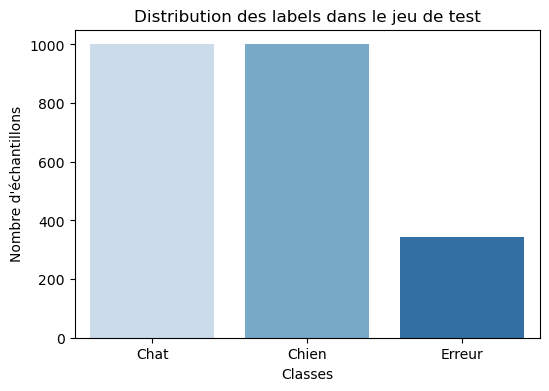

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger le fichier CSV du mapping de test
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"
df = pd.read_csv(TEST_CSV)

# Vérifier la distribution des labels
label_counts = df["label"].value_counts().sort_index()

# Affichage des résultats
print("🔍 Répartition des labels dans le jeu de test :")
print(label_counts)

# Visualisation
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues")
plt.xticks([0,1,2], ["Chat", "Chien", "Erreur"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des labels dans le jeu de test")
plt.show()


✅ Modèle chargé avec succès !

🔍 Répartition des labels dans le jeu de test :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


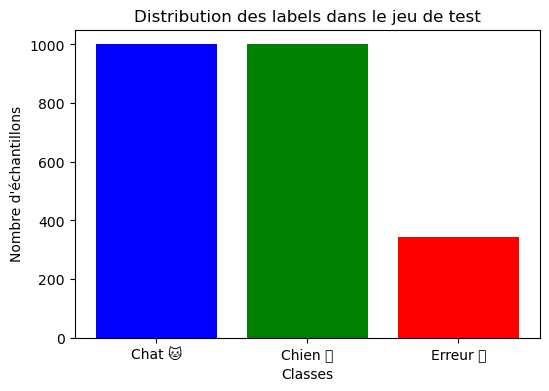

🔄 Nombre d'échantillons de test utilisés : 2343


ValueError: in user code:

    File "c:\Users\briac\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\briac\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\briac\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\briac\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\briac\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\briac\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "fusion_model" is incompatible with the layer: expected shape=(None, 64, 64, 1), found shape=(None, 1, 64, 64, 1)


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd

# 🛠️ Configuration
FUSION_MODEL_PATH = r"C:\Users\briac\Desktop\projet_3\models\image_audio_fusion_model_v5.keras"
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"

# ✅ Charger le modèle correct
try:
    fusion_model = tf.keras.models.load_model(FUSION_MODEL_PATH)
    print("✅ Modèle chargé avec succès !")
except OSError as e:
    print(f"❌ Erreur lors du chargement du modèle : {e}")
    exit()

# 🔍 Vérifier la distribution des labels dans le jeu de test
df = pd.read_csv(TEST_CSV)
label_counts = df["label"].value_counts().sort_index()

print("\n🔍 Répartition des labels dans le jeu de test :")
print(label_counts)

plt.figure(figsize=(6,4))
plt.bar(["Chat 🐱", "Chien 🐶", "Erreur ❌"], label_counts.values, color=["blue", "green", "red"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des labels dans le jeu de test")
plt.show()

# 🎨 Prétraitement de l'image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Image non trouvée : {image_path}")
        return None
    img = cv2.resize(img, (64, 64)) / 255.0
    return img.reshape(1, 64, 64, 1)

# 🎵 Prétraitement de l'audio (spectrogramme)
def preprocess_audio(audio_path):
    spec_path = audio_path.replace(r"\cleaned\audio", r"\spectrograms").replace(".wav", ".png")
    if not os.path.exists(spec_path):
        print(f"❌ Spectrogramme non trouvé : {spec_path}")
        return None
    spec_img = cv2.imread(spec_path, cv2.IMREAD_GRAYSCALE)
    if spec_img is None:
        print(f"❌ Erreur lors du chargement du spectrogramme : {spec_path}")
        return None
    spec_img = cv2.resize(spec_img, (64, 64)) / 255.0
    return spec_img.reshape(1, 64, 64, 1)

# 📂 Chargement des données de test
X_images, X_audio, y_true = [], [], []

for _, row in df.iterrows():
    image_path, audio_path = row["image_path"], row["audio_path"]
    
    if not os.path.exists(image_path) or not os.path.exists(audio_path):
        print(f"⚠️ Fichier manquant : {image_path} ou {audio_path}")
        continue
    
    img = preprocess_image(image_path)
    aud = preprocess_audio(audio_path)

    if img is None or aud is None:
        continue

    X_images.append(img)
    X_audio.append(aud)
    y_true.append(int(row["label"]))

if len(X_images) == 0 or len(X_audio) == 0:
    print("❌ Aucun échantillon de test valide trouvé.")
    exit()

X_images = np.array(X_images)
X_audio = np.array(X_audio)
y_true = np.array(y_true)

print(f"🔄 Nombre d'échantillons de test utilisés : {X_images.shape[0]}")

# 🔮 Prédictions du modèle
y_pred_probs = fusion_model.predict([X_images, X_audio])
y_pred = np.argmax(y_pred_probs, axis=1)

# 📊 Probabilités moyennes par classe
mean_probs = pd.DataFrame(y_pred_probs, columns=["Chat 🐱", "Chien 🐶", "Erreur ❌"]).mean()
print("\n📊 Probabilités moyennes des prédictions par classe :")
print(mean_probs)

# 🎯 Vérifier la classification
from sklearn.metrics import classification_report, confusion_matrix

label_names = ["Chat 🐱", "Chien 🐶", "Erreur ❌"]
print("\n📌 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=label_names))

# 🔥 Matrice de confusion
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion - Modèle Fusionné")
plt.show()

# 🎯 Tester un seuil pour améliorer la classe "Erreur"
seuil_erreur = 0.3  # Ajuster selon besoin
y_pred_custom = np.where(y_pred_probs[:, 2] > seuil_erreur, 2, np.argmax(y_pred_probs, axis=1))

print("\n📌 Rapport de classification avec seuil ajusté :")
print(classification_report(y_true, y_pred_custom, target_names=label_names))

# 📊 Comparaison des résultats avant/après ajustement
plt.figure(figsize=(6,4))
plt.bar(["Avant Ajustement", "Après Ajustement"], [np.mean(y_pred == y_true)*100, np.mean(y_pred_custom == y_true)*100], color=["red", "green"])
plt.ylabel("Accuracy (%)")
plt.title("Comparaison de l'Accuracy Avant/Après Ajustement du Seuil")
plt.show()


✅ Modèle chargé avec succès !

🔍 Répartition des labels dans le jeu de test :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


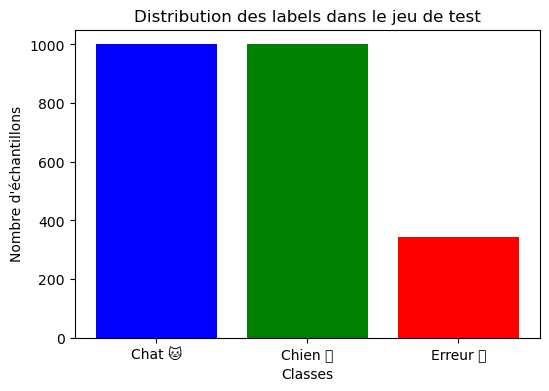

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [11]:
import tensorflow as tf
import numpy as np
import cv2
import librosa
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 🛠️ Configuration
FUSION_MODEL_PATH = r"C:\Users\briac\Desktop\projet_3\models\image_audio_fusion_model_v5.keras"
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"

# ✅ Charger le modèle correct
try:
    fusion_model = tf.keras.models.load_model(FUSION_MODEL_PATH)
    print("✅ Modèle chargé avec succès !")
except OSError as e:
    print(f"❌ Erreur lors du chargement du modèle : {e}")
    exit()

# 🔍 Vérifier la distribution des labels dans le jeu de test
df = pd.read_csv(TEST_CSV)
label_counts = df["label"].value_counts().sort_index()

print("\n🔍 Répartition des labels dans le jeu de test :")
print(label_counts)

plt.figure(figsize=(6,4))
plt.bar(["Chat 🐱", "Chien 🐶", "Erreur ❌"], label_counts.values, color=["blue", "green", "red"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des labels dans le jeu de test")
plt.show()

# 🎨 Prétraitement de l'image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Image non trouvée : {image_path}")
        return None
    img = cv2.resize(img, (64, 64)) / 255.0
    return img.reshape(64, 64, 1)  # Shape correct (64, 64, 1)

# 🎵 Prétraitement de l'audio (spectrogramme)
def preprocess_audio(audio_path):
    spec_path = audio_path.replace(r"\cleaned\audio", r"\spectrograms").replace(".wav", ".png")
    if not os.path.exists(spec_path):
        print(f"❌ Spectrogramme non trouvé : {spec_path}")
        return None
    spec_img = cv2.imread(spec_path, cv2.IMREAD_GRAYSCALE)
    if spec_img is None:
        print(f"❌ Erreur lors du chargement du spectrogramme : {spec_path}")
        return None
    spec_img = cv2.resize(spec_img, (64, 64)) / 255.0
    return spec_img.reshape(64, 64, 1)  # Shape correct (64, 64, 1)

# 📂 Chargement des données de test
X_images, X_audio, y_true = [], [], []

for _, row in df.iterrows():
    image_path, audio_path = row["image_path"], row["audio_path"]
    
    if not os.path.exists(image_path) or not os.path.exists(audio_path):
        print(f"⚠️ Fichier manquant : {image_path} ou {audio_path}")
        continue
    
    img = preprocess_image(image_path)
    aud = preprocess_audio(audio_path)

    if img is None or aud is None:
        continue

    X_images.append(img)
    X_audio.append(aud)
    y_true.append(int(row["label"]))

if len(X_images) == 0 or len(X_audio) == 0:
    print("❌ Aucun échantillon de test valide trouvé.")
    exit()

X_images = np.array(X_images)
X_audio = np.array(X_audio)
y_true = np.array(y_true)

# 🚨 Correction du problème de shape (enlever la dimension superflue)
X_images = X_images.squeeze(axis=1)  # Shape devient (None, 64, 64, 1)
X_audio = X_audio.squeeze(axis=1)  # Shape devient (None, 64, 64, 1)

print(f"🔄 Nombre d'échantillons de test utilisés : {X_images.shape[0]}")

# 🔮 Prédictions du modèle
y_pred_probs = fusion_model.predict([X_images, X_audio])
y_pred = np.argmax(y_pred_probs, axis=1)

# 📊 Probabilités moyennes par classe
mean_probs = pd.DataFrame(y_pred_probs, columns=["Chat 🐱", "Chien 🐶", "Erreur ❌"]).mean()
print("\n📊 Probabilités moyennes des prédictions par classe :")
print(mean_probs)

# 🎯 Vérifier la classification
from sklearn.metrics import classification_report, confusion_matrix

label_names = ["Chat 🐱", "Chien 🐶", "Erreur ❌"]
print("\n📌 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=label_names))

# 🔥 Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion - Modèle Fusionné")
plt.show()

# 🎯 Tester un seuil pour améliorer la classe "Erreur"
seuil_erreur = 0.3  # Ajuster selon besoin
y_pred_custom = np.where(y_pred_probs[:, 2] > seuil_erreur, 2, np.argmax(y_pred_probs, axis=1))

print("\n📌 Rapport de classification avec seuil ajusté :")
print(classification_report(y_true, y_pred_custom, target_names=label_names))

# 📊 Comparaison des résultats avant/après ajustement
plt.figure(figsize=(6,4))
plt.bar(["Avant Ajustement", "Après Ajustement"], [np.mean(y_pred == y_true)*100, np.mean(y_pred_custom == y_true)*100], color=["red", "green"])
plt.ylabel("Accuracy (%)")
plt.title("Comparaison de l'Accuracy Avant/Après Ajustement du Seuil")
plt.show()


✅ Modèle chargé avec succès !

🔍 Répartition des labels dans le jeu de test :
label
0    1000
1    1000
2     343
Name: count, dtype: int64


C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


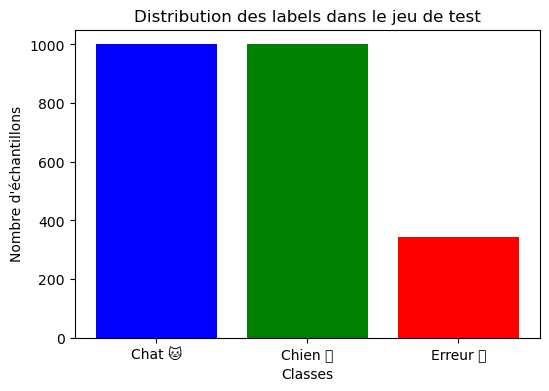

🛠️ Shape initiale de X_images: (2343, 64, 64, 1)
🛠️ Shape initiale de X_audio: (2343, 64, 64, 1)
✅ Shape finale de X_images: (2343, 64, 64, 1)
✅ Shape finale de X_audio: (2343, 64, 64, 1)
🔄 Nombre d'échantillons de test utilisés : 2343
74/74 [==============================] - 2s 29ms/step

📊 Probabilités moyennes des prédictions par classe :
Chat 🐱      0.505749
Chien 🐶     0.493902
Erreur ❌    0.000349
dtype: float32

📌 Rapport de classification :
              precision    recall  f1-score   support

      Chat 🐱       0.83      0.98      0.90      1000
     Chien 🐶       0.84      0.97      0.90      1000
    Erreur ❌       0.00      0.00      0.00       343

    accuracy                           0.84      2343
   macro avg       0.56      0.65      0.60      2343
weighted avg       0.71      0.84      0.77      2343



c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\seaborn\util

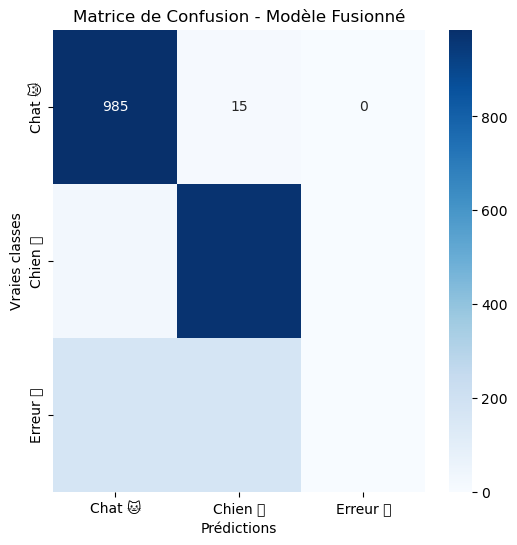

c:\Users\briac\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


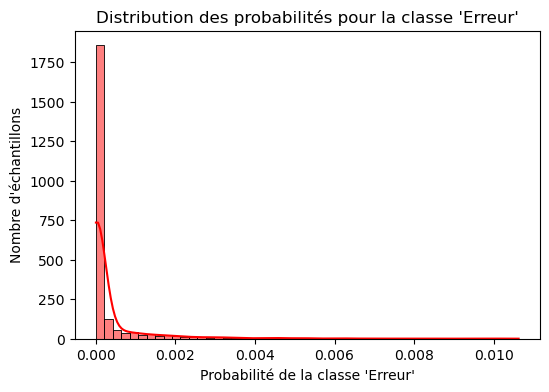

c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\briac\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🔍 2 échantillons ont une probabilité > 0.01 pour 'Erreur' :
🟢 Image: C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\images\test\dogs\dog.4572.jpg | 🔊 Audio: C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\test\dogs\dog0252.wav | Prob Erreur: 0.0106
🟢 Image: C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\images\test\cats\cat.4658.jpg | 🔊 Audio: C:\Users\briac\Desktop\projet_3\data\data_fusion_model\cleaned\audio\test\dogs\dog0033.wav | Prob Erreur: 0.0100

📌 Rapport de classification avec seuil ajusté :
              precision    recall  f1-score   support

      Chat 🐱       0.83      0.98      0.90      1000
     Chien 🐶       0.84      0.97      0.90      1000
    Erreur ❌       0.00      0.00      0.00       343

    accuracy                           0.84      2343
   macro avg       0.56      0.65      0.60      2343
weighted avg       0.71      0.84      0.77      2343



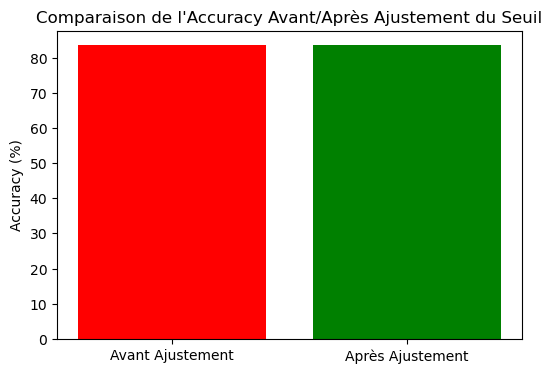

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 🛠️ Configuration
FUSION_MODEL_PATH = r"C:\Users\briac\Desktop\projet_3\models\image_audio_fusion_model_v5.keras"
TEST_CSV = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\test_image_audio_mapping.csv"

# ✅ Charger le modèle correct
try:
    fusion_model = tf.keras.models.load_model(FUSION_MODEL_PATH)
    print("✅ Modèle chargé avec succès !")
except OSError as e:
    print(f"❌ Erreur lors du chargement du modèle : {e}")
    exit()

# 🔍 Vérifier la distribution des labels
df = pd.read_csv(TEST_CSV)
label_counts = df["label"].value_counts().sort_index()

print("\n🔍 Répartition des labels dans le jeu de test :")
print(label_counts)

plt.figure(figsize=(6,4))
plt.bar(["Chat 🐱", "Chien 🐶", "Erreur ❌"], label_counts.values, color=["blue", "green", "red"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des labels dans le jeu de test")
plt.show()

# 🎨 Prétraitement de l'image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Image non trouvée : {image_path}")
        return None
    img = cv2.resize(img, (64, 64)) / 255.0
    return img.reshape(64, 64, 1)  # Shape correct (64, 64, 1)

# 🎵 Prétraitement de l'audio (spectrogramme)
def preprocess_audio(audio_path):
    spec_path = audio_path.replace(r"\cleaned\audio", r"\spectrograms").replace(".wav", ".png")
    if not os.path.exists(spec_path):
        print(f"❌ Spectrogramme non trouvé : {spec_path}")
        return None
    spec_img = cv2.imread(spec_path, cv2.IMREAD_GRAYSCALE)
    if spec_img is None:
        print(f"❌ Erreur lors du chargement du spectrogramme : {spec_path}")
        return None
    spec_img = cv2.resize(spec_img, (64, 64)) / 255.0
    return spec_img.reshape(64, 64, 1)  # Shape correct (64, 64, 1)

# 📂 Chargement des données de test
X_images, X_audio, y_true = [], [], []

for _, row in df.iterrows():
    image_path, audio_path = row["image_path"], row["audio_path"]
    
    if not os.path.exists(image_path) or not os.path.exists(audio_path):
        print(f"⚠️ Fichier manquant : {image_path} ou {audio_path}")
        continue
    
    img = preprocess_image(image_path)
    aud = preprocess_audio(audio_path)

    if img is None or aud is None:
        continue

    X_images.append(img)
    X_audio.append(aud)
    y_true.append(int(row["label"]))

if len(X_images) == 0 or len(X_audio) == 0:
    print("❌ Aucun échantillon de test valide trouvé.")
    exit()

X_images = np.array(X_images)
X_audio = np.array(X_audio)
y_true = np.array(y_true)

# 🚨 **Correction des formes de données**
print(f"🛠️ Shape initiale de X_images: {X_images.shape}")
print(f"🛠️ Shape initiale de X_audio: {X_audio.shape}")

# 🔧 Correction dynamique des dimensions
if X_images.ndim == 5:  # Trop de dimensions
    X_images = X_images.reshape(X_images.shape[0], 64, 64, 1)

if X_audio.ndim == 5:  # Trop de dimensions
    X_audio = X_audio.reshape(X_audio.shape[0], 64, 64, 1)

print(f"✅ Shape finale de X_images: {X_images.shape}")
print(f"✅ Shape finale de X_audio: {X_audio.shape}")

print(f"🔄 Nombre d'échantillons de test utilisés : {X_images.shape[0]}")

# 🔮 Prédictions du modèle
y_pred_probs = fusion_model.predict([X_images, X_audio])
y_pred = np.argmax(y_pred_probs, axis=1)

# 📊 Probabilités moyennes par classe
mean_probs = pd.DataFrame(y_pred_probs, columns=["Chat 🐱", "Chien 🐶", "Erreur ❌"]).mean()
print("\n📊 Probabilités moyennes des prédictions par classe :")
print(mean_probs)

# 🎯 Vérifier la classification
from sklearn.metrics import classification_report, confusion_matrix

label_names = ["Chat 🐱", "Chien 🐶", "Erreur ❌"]
print("\n📌 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=label_names))

# 🔥 Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de Confusion - Modèle Fusionné")
plt.show()

# 🎯 Tester un seuil pour améliorer la classe "Erreur"
seuil_erreur = 0.3  # Ajuster selon besoin
y_pred_custom = np.where(y_pred_probs[:, 2] > seuil_erreur, 2, np.argmax(y_pred_probs, axis=1))
import seaborn as sns

# 📊 Histogramme des probabilités prédites pour la classe "Erreur"
plt.figure(figsize=(6,4))
sns.histplot(y_pred_probs[:, 2], bins=50, kde=True, color="red")
plt.xlabel("Probabilité de la classe 'Erreur'")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des probabilités pour la classe 'Erreur'")
plt.show()

# 🔍 Afficher quelques exemples avec une probabilité élevée d'erreur
high_error_indices = np.where(y_pred_probs[:, 2] > 0.01)[0]  # Seuil faible pour voir si quelques cas existent
if len(high_error_indices) > 0:
    print(f"🔍 {len(high_error_indices)} échantillons ont une probabilité > 0.01 pour 'Erreur' :")
    for i in high_error_indices[:10]:  # Afficher les 10 premiers
        print(f"🟢 Image: {df.iloc[i]['image_path']} | 🔊 Audio: {df.iloc[i]['audio_path']} | Prob Erreur: {y_pred_probs[i, 2]:.4f}")
else:
    print("❌ Aucun échantillon avec une probabilité > 0.01 pour la classe 'Erreur'.")


print("\n📌 Rapport de classification avec seuil ajusté :")
print(classification_report(y_true, y_pred_custom, target_names=label_names))

# 📊 Comparaison des résultats avant/après ajustement
plt.figure(figsize=(6,4))
plt.bar(["Avant Ajustement", "Après Ajustement"], [np.mean(y_pred == y_true)*100, np.mean(y_pred_custom == y_true)*100], color=["red", "green"])
plt.ylabel("Accuracy (%)")
plt.title("Comparaison de l'Accuracy Avant/Après Ajustement du Seuil")
plt.show()



🔍 Répartition des labels dans le jeu d'entraînement :
label
0    4000
1    3999
2    1570
Name: count, dtype: int64


C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\briac\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


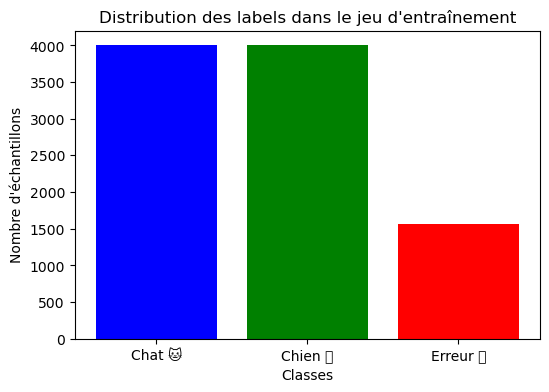

In [5]:
# 🔍 Vérifier l'équilibrage des classes dans les données d'entraînement
train_csv = r"C:\Users\briac\Desktop\projet_3\data\data_fusion_model\fusion_mapping.csv"
df_train = pd.read_csv(train_csv)

print("\n🔍 Répartition des labels dans le jeu d'entraînement :")
print(df_train["label"].value_counts().sort_index())

plt.figure(figsize=(6,4))
plt.bar(["Chat 🐱", "Chien 🐶", "Erreur ❌"], df_train["label"].value_counts().sort_index().values, color=["blue", "green", "red"])
plt.xlabel("Classes")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des labels dans le jeu d'entraînement")
plt.show()


In [6]:
fusion_model.summary()


Model: "fusion_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 audio_input (InputLayer)    [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 image_feature_extractor (F  (None, 256)                  813792    ['image_input[0][0]']         
 unctional)                                                                                       
                                                                                                  
 audio_feature_extractor (F  (None, 256)                  6497280   ['audio_input[0][0]

In [1]:
import collections

# Compter le nombre d'exemples par classe
label_counts = collections.Counter(y_labels)
print("Répartition des labels dans le dataset :", label_counts)


NameError: name 'y_labels' is not defined

In [6]:
import tensorflow as tf

keras_model_path = "C:/Users/briac/Desktop/projet_3/models/audio.keras"
h5_model_path = "C:/Users/briac/Desktop/projet_3/models/audio.h5"

# Charger le modèle au format .keras
model = tf.keras.models.load_model(keras_model_path, compile=False)

# Sauvegarder le modèle au format .h5
model.save(h5_model_path)

print(f"✅ Conversion terminée : {h5_model_path}")


✅ Conversion terminée : C:/Users/briac/Desktop/projet_3/models/audio.h5


In [1]:
import os

# Chemins des fichiers critiques
MAPPING_CSV = "data/data_fusion_model/fusion_mapping.csv"
OLD_MODEL_PATH = "models/image_audio_fusion_new_model.h5"
DATA_DIR = "data/data_fusion_model/cleaned/"
SPECTROGRAM_DIR = "data/data_fusion_model/spectrograms/"

# 🔎 Vérification du mapping CSV
if os.path.exists(MAPPING_CSV):
    print(f"✅ CSV trouvé : {MAPPING_CSV}")
else:
    print(f"❌ ERREUR: {MAPPING_CSV} manquant !")

# 🔎 Vérification du modèle existant
if os.path.exists(OLD_MODEL_PATH):
    print(f"✅ Modèle trouvé : {OLD_MODEL_PATH}")
else:
    print(f"❌ ERREUR: Modèle non trouvé : {OLD_MODEL_PATH}")

# 🔎 Vérification des données (images et spectrogrammes)
if os.path.exists(DATA_DIR):
    print(f"✅ Dossier images/audio trouvé : {DATA_DIR}")
    print(f"📸 {len(os.listdir(DATA_DIR))} fichiers trouvés")
else:
    print(f"❌ ERREUR: {DATA_DIR} manquant !")

if os.path.exists(SPECTROGRAM_DIR):
    print(f"✅ Dossier spectrogrammes trouvé : {SPECTROGRAM_DIR}")
    print(f"🎵 {len(os.listdir(SPECTROGRAM_DIR))} fichiers trouvés")
else:
    print(f"❌ ERREUR: {SPECTROGRAM_DIR} manquant !")


❌ ERREUR: data/data_fusion_model/fusion_mapping.csv manquant !
❌ ERREUR: Modèle non trouvé : models/image_audio_fusion_new_model.h5
❌ ERREUR: data/data_fusion_model/cleaned/ manquant !
❌ ERREUR: data/data_fusion_model/spectrograms/ manquant !


In [3]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# --- 📂 Configuration et chemins ---
MAPPING_CSV = "data/data_fusion_model/fusion_mapping.csv"
MODEL_PATH = "models/image_audio_fusion_new_model.h5"  # Sauvegarde en `.h5`

tf.keras.models.load_model(MODEL_PATH, compile=False)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models/image_audio_fusion_new_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
image_model = tf.keras.models.load_model("models/image.keras")
audio_model = tf.keras.models.load_model("models/audio.keras")
print(image_model.summary())
print(audio_model.summary())


ValueError: File not found: filepath=models/image.keras. Please ensure the file is an accessible `.keras` zip file.